Import duckdb to be able to use sql

In [44]:
import duckdb
import pandas as pd
import re
import matplotlib as plt

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

description.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,staging,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,sakila,staging,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,sakila,staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,sakila,staging,actor,"[actor_id, first_name, last_name, last_update,...","[DECIMAL(38,9), VARCHAR, VARCHAR, TIMESTAMP, V...",False
4,sakila,staging,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False


storing data into dictionary with dfs

In [45]:
dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()

            duckdb.register(name, dfs[name])



# TASK 1

a)

In [46]:
duckdb.sql("""--sql
    SELECT
           title,
           length
    FROM film
    WHERE
           length >= 180;
""").df().head()

,title,length
0,ALLEY EVOLUTION,180
1,ANALYZE HOOSIERS,181
2,BAKED CLEOPATRA,182
3,CATCH AMISTAD,183
4,CHICAGO NORTH,185


In [47]:
#using pandas

sorted_df = dfs["film"][dfs["film"]['length'] >= 180]
result = sorted_df[['title', 'length']]

result.head()

,title,length
15,ALLEY EVOLUTION,180
23,ANALYZE HOOSIERS,181
49,BAKED CLEOPATRA,182
127,CATCH AMISTAD,183
140,CHICAGO NORTH,185


b)

In [48]:
duckdb.sql("""--sql
    SELECT
           title,
           rating,
           length,
           description
    FROM film
    WHERE (' ' || title || ' ') LIKE '% LOVE %';
""").df()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [49]:
#trial and error
# duckdb.sql("""--sql
#         SELECT 
#             title,
#             rating,
#             length,
#             description
#         FROM film
#         WHERE (' ' || title || ' ') LIKE '% LOVE %';
#         --WHERE title ~ '(^|[^A-Za-z0-9_])love($|[^A-Za-z0-9_])'
#         --WHERE title ~ '(?i)(^| )love( |$)'
#         --WHERE title LIKE 'LOVE %'
#         --    OR title LIKE '% LOVE %' 
#     --    OR title LIKE 'LOVE'
#     --    OR title LIKE '% LOVE';
# """).df()

In [50]:
#using pandas for b
filtered_df = dfs["film"][dfs["film"]['title'].str.contains(r"\blove\b", case=False, na=False)]
result = filtered_df[['title', 'rating', 'length', 'description']]

result


,title,rating,length,description
373,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
447,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
457,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
510,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
534,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


c)

In [51]:
duckdb.sql("""--sql
    SELECT
            MIN(length) as min_length,
            MAX(length) as max_length,
            ROUND(AVG(length)) as average_length,
            ROUND(MEDIAN(length)) as median_length
    FROM film;
""").df().head()

,min_length,max_length,average_length,median_length
0,46,185,115.0,114.0


In [52]:
#using pandas

film = dfs["film"]

stats = pd.DataFrame({
    "min_length": [film["length"].min()],
    "max_length": [film["length"].max()],
    "average_length": [round(film["length"].mean())],
    "median_length": [round(film["length"].median())]
})

stats


,min_length,max_length,average_length,median_length
0,46,185,115,114


d)

In [53]:
duckdb.sql("""--sql
    SELECT
         -- måste räkna ut vad det kostar per dag genom att dividera kostnad med dagar
            title,
            rental_rate / rental_duration as cost_per_day
    FROM film
    ORDER BY cost_per_day DESC
    LIMIT 10;
""").df()

,title,cost_per_day
0,BACKLASH UNDEFEATED,1.663333
1,BILKO ANONYMOUS,1.663333
2,BEAST HUNCHBACK,1.663333
3,AUTUMN CROW,1.663333
4,ACE GOLDFINGER,1.663333
5,CARIBBEAN LIBERTY,1.663333
6,BEHAVIOR RUNAWAY,1.663333
7,CASPER DRAGONFLY,1.663333
8,AMERICAN CIRCUS,1.663333
9,CASUALTIES ENCINO,1.663333


In [54]:
#using pandas


e)

In [ ]:
duckdb.sql("""--sql
    SELECT 
            a.actor_id,
            a.first_name,
            a.last_name,
            COUNT(fa.film_id) as number_films
    FROM actor as a
    LEFT JOIN film_actor as fa
           ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY number_films DESC
    LIMIT 10;
""").df()

,actor_id,first_name,last_name,number_films
0,107.0,GINA,DEGENERES,42
1,102.0,WALTER,TORN,41
2,198.0,MARY,KEITEL,40
3,181.0,MATTHEW,CARREY,39
4,23.0,SANDRA,KILMER,37
5,81.0,SCARLETT,DAMON,36
6,13.0,UMA,WOOD,35
7,60.0,HENRY,BERRY,35
8,158.0,VIVIEN,BASINGER,35
9,144.0,ANGELA,WITHERSPOON,35


In [ ]:
#using pandas

f)

# TASK 2

a)

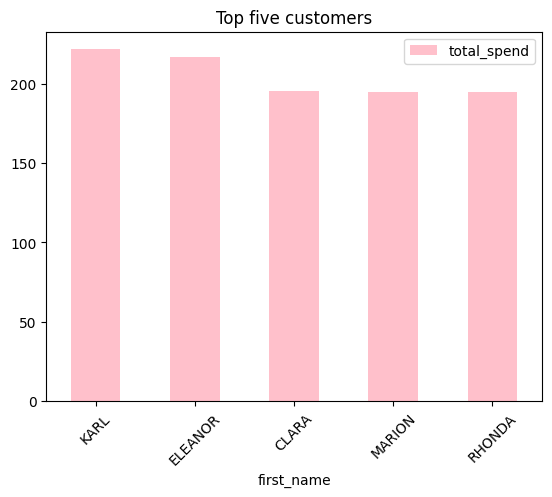

In [63]:
top_customer = duckdb.sql("""--sql
    SELECT 
           c.customer_id,
           c.first_name,
           c.last_name,
           SUM(p.amount) as total_spend
    FROM customer as c
    LEFT JOIN payment as p
           ON c.customer_id = p.customer_id
    GROUP BY c.customer_id, c.first_name, c.last_name
    ORDER BY total_spend DESC
""").df()

ax = top_customer.head(5).plot(
    kind = "bar",
    x = "first_name",
    y = "total_spend",
    title = "Top five customers",
    color="pink",
    rot=45
)


b)